# Training and evaluation

In [1]:
# Import the libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

When passing data to the built-in training loops of a model, you should either use:
- **NumPy arrays** (if your data is small and fits in memory)
- or **tf.data Dataset** objects. 

## A first example

In [2]:
# First, we build a model to classify the digits from MNIST dataset
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10k samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
# Let's specify the training configuration
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [5]:
# Also, the above cell could be specified by:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

In [6]:
# Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Epoch 1/2
782/782 [==============================] - 4s 5ms/step - loss: 0.3511 - sparse_categorical_accuracy: 0.9004 - val_loss: 0.2011 - val_sparse_categorical_accuracy: 0.9427
Epoch 2/2
782/782 [==============================] - 5s 6ms/step - loss: 0.1595 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.1280 - val_sparse_categorical_accuracy: 0.9620


In [7]:
# We have the history of the training here:
history.history

{'loss': [0.3511173725128174, 0.15951725840568542],
 'sparse_categorical_accuracy': [0.900439977645874, 0.9524999856948853],
 'val_loss': [0.2010723203420639, 0.127974271774292],
 'val_sparse_categorical_accuracy': [0.9427000284194946, 0.9620000123977661]}

In [8]:
# Once the model is trained, we evaluate it
results = model.evaluate(x_test, y_test, batch_size=128)
print(f"test loss, test acc: {results}")

79/79 [==============================] - 0s 4ms/step - loss: 0.1326 - sparse_categorical_accuracy: 0.9605
test loss, test acc: [0.13256731629371643, 0.9605000019073486]


In [9]:
# Let's write functions to get the uncompiled and compiled model for later reuse
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

## Testing some other optimizers, losses and metrics

### Example: changing the optimizer to SGD

In [10]:
model.compile(
    optimizer=keras.optimizers.SGD(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [11]:
# Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Epoch 1/2
782/782 [==============================] - 5s 5ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.9689 - val_loss: 0.1134 - val_sparse_categorical_accuracy: 0.9666
Epoch 2/2
782/782 [==============================] - 4s 6ms/step - loss: 0.1002 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.1123 - val_sparse_categorical_accuracy: 0.9669


In [12]:
results = model.evaluate(x_test, y_test, batch_size=128)
print(f"test loss, test acc: {results}")

79/79 [==============================] - 0s 5ms/step - loss: 0.1140 - sparse_categorical_accuracy: 0.9652
test loss, test acc: [0.11400018632411957, 0.9652000069618225]


### Custom losses

There are two ways of implementing custom losses:
- Pass the loss as a function:

In [13]:
# Let's create a function that takes 'y_true' and 'y_pred' and computes the MSE
def custom_mean_squared_error(y_true, y_pred):
  return tf.math.reduce_mean(tf.square(y_true - y_pred))  # MSE formula

In [14]:
# Get the model and compile it using the custom function
model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=custom_mean_squared_error
)

In [15]:
# One-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)

print(y_train[0])
print(y_train_one_hot[0])

5.0
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


In [16]:
# Train the model
model.fit(
    x_train,
    y_train_one_hot,
    batch_size=64,
    epochs=1
)

782/782 [==============================] - 3s 3ms/step - loss: 0.0154


- Subclassing

In [17]:
# Let's create a MSE with a regularization penalty
class CustomMSE(keras.losses.Loss):
  
  def __init__(self, regularization_factor=0.1, name="custom_mse"):
    super().__init__(name=name)
    self.regularization_factor = regularization_factor

  def call(self, y_true, y_pred):
    mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
    reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
    return mse + reg * self.regularization_factor


In [18]:
# Train the model using our custom loss function
model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=CustomMSE(regularization_factor=0.3)
    )

model.fit(
    x_train,
    y_train_one_hot,
    batch_size=64,
    epochs=1
)

782/782 [==============================] - 3s 3ms/step - loss: 0.0820


### Custom metrics
- Subclassing:

In [24]:
# Let's implement a metric that counts how many samples where correctly 
# classified

class CategoricalTruePositives(keras.metrics.Metric):  # subclass Metric

  # Implement the constructor
  def __init__(self, name="categorical_true_positives", **kwargs):
    """Creates state variables"""
    super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name="ctp", initializer="zeros")

  # Implement an updater
  def update_state(self, y_true, y_pred, sample_weight=None):
    """Updates the state variables"""
    y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
    values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
    values = tf.cast(values, "float32")
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, "float32")
      values = tf.multiply(values, sample_weight)
    self.true_positives.assign_add(tf.reduce_sum(values))

  # Implement the method to return the computation
  def result(self):
    """Computes the final results"""
    return self.true_positives

  # Implement a reset
  def reset_state(self):
    """Reinitializes the state"""
    self.true_positives.assign(0.0)

In [25]:
# Now, let's compile and train the model using our custom metric
model = get_uncompiled_model()

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)

model.fit(x_train, y_train, batch_size=64, epochs=3)


Epoch 1/3
782/782 [==============================] - 4s 4ms/step - loss: 0.3358 - categorical_true_positives: 45167.0000
Epoch 2/3
782/782 [==============================] - 3s 4ms/step - loss: 0.1555 - categorical_true_positives: 47672.0000
Epoch 3/3
782/782 [==============================] - 3s 4ms/step - loss: 0.1130 - categorical_true_positives: 48311.0000


In [26]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1457 - categorical_true_positives: 9552.0000


[0.14565840363502502, 9552.0]

### Adding losses and metrics:

In [29]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        # To add the loss to the "main" loss during training
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 5s 6ms/step - loss: 2.5568


In [30]:
# The same thing can be done with metrics using 'add_metric':
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 4s 4ms/step - loss: 0.3403 - std_of_activation: 0.9836


In [31]:
# The same can be done using the functional API
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 6s 6ms/step - loss: 2.4961 - std_of_activation: 0.0019


## Setting apart a validation holdout set

In [33]:
# To use a % of the data for validation, we can use:
model = get_compiled_model()
model.fit(
    x_train,
    y_train,
    batch_size=64,
    validation_split=0.2,  # use 20% of the data for validation
    epochs=1
)

625/625 [==============================] - 5s 6ms/step - loss: 0.3674 - sparse_categorical_accuracy: 0.8960 - val_loss: 0.2222 - val_sparse_categorical_accuracy: 0.9330


In [34]:
# You can use 'validation_split' when training with numpy data
type(x_train)

numpy.ndarray

The way the validation is computed is by taking the last x% samples of the arrays received by the fit() call, before any shuffling.

## Using tf.data.Dataset

The tf.data API is a set of utilities in TensorFlow 2.0 for loading and preprocessing data in a way that's fast and scalable.

In [36]:
# Let's see a first example: you can pass a Dataset instance to the methods
# fit(), evaluate() and predict():

model = get_compiled_model()

# Let's create our Dataset 
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Shuffle and slice
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# And now do the same with the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(64)


In [37]:
# Now, train the model using Dataset instances.
# Since the dataset already takes care of batching, we don't pass a batch_size
model.fit(train_dataset, epochs=3)

Epoch 1/3
782/782 [==============================] - 5s 6ms/step - loss: 0.3453 - sparse_categorical_accuracy: 0.9030
Epoch 2/3
782/782 [==============================] - 4s 5ms/step - loss: 0.1623 - sparse_categorical_accuracy: 0.9526
Epoch 3/3
782/782 [==============================] - 4s 6ms/step - loss: 0.1165 - sparse_categorical_accuracy: 0.9654


In [38]:
# And finally, evaluate the model on a dataset too
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

157/157 [==============================] - 1s 4ms/step - loss: 0.1137 - sparse_categorical_accuracy: 0.9670


{'loss': 0.11367695033550262,
 'sparse_categorical_accuracy': 0.9670000076293945}

In [39]:
# If you want to specify the number of batches per epoch, you can use:
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

# In this case, you use 100 batches per epoch and at the end of each epoch you
# don't reset the dataset, you just keep drawing the next batches.

Epoch 1/3
100/100 [==============================] - 0s 4ms/step - loss: 0.0914 - sparse_categorical_accuracy: 0.9747
Epoch 2/3
100/100 [==============================] - 0s 4ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.9695
Epoch 3/3
100/100 [==============================] - 0s 4ms/step - loss: 0.0865 - sparse_categorical_accuracy: 0.9730


In [40]:
# You can create and pass a validation dataset too:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

782/782 [==============================] - 6s 7ms/step - loss: 0.0847 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.0980 - val_sparse_categorical_accuracy: 0.9714


In [41]:
# Similarly, you can control how many validation steps you want to run by using:
model.fit(train_dataset, 
          epochs=1,
          validation_data=val_dataset,
          validation_steps=10  # run validation using the first 10 batches
          )

782/782 [==============================] - 4s 6ms/step - loss: 0.0714 - sparse_categorical_accuracy: 0.9780 - val_loss: 0.1515 - val_sparse_categorical_accuracy: 0.9641


The argument validation_split is not supported when training from Dataset objects.

## Using other input formats

Apart from NumpY arrays and Dataset, it's possible to train a Keras model using:
- Pandas dataframes.
- or from Python generators that yield batches of data & labels -> keras.utils.Sequence.

It's recommended to:
- Use NumPy data if the data is small and fits in memory.
- Dataset for large dataset and distributed training.
- Sequence objects for large dataset and custom Python-side processing. 

In [43]:
# An example using keras.utils.Sequence:
from skimage.io import imread
from skimage.transform import resize
import numpy as np

class CIFAR10Sequence(keras.utils.Sequence):
  def __init__(self, filenames, labels, batch_size):
    """Constructor"""
    self.filenames = filenames  # list with paths to images
    self.labels = labels
    self.batch_size = batch_size

  def __len__(self):
    """Returns the length in number of batches"""
    return int(np.ceil(len(self.filenames) / float(self.batch_size)))

  def __getitem__(self, idx):
    """Returns a complete batch"""
    batch_x = self.filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]
    return np.array(
                     [resize(imread(filename), (200, 200)) for filename in batch_x],
                    np.array(batch_y)
                    )

# Create the sequence class and train the model    
# filenames = [...]
# labels = [...]
# batch_size = ...    
# sequence = CIFAR10Sequence(filenames, labels, batch_size)
# model.fit(sequence, epochs=10)

## Using sample and class weighting

### Class weights
This can be used to balance classes without resampling, or to train a model that gives more importance to a particular class.

In [44]:
import numpy as np

# We define a dict with the weight per class
class_weight = {
    0: 1.0,  # this means we give a weight of 1.0 to class 0
    1: 1.0, 
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 2.0,  # here we are making the class 5 to be more important than the others
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

# And we can train with the weights using:
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

782/782 [==============================] - 6s 6ms/step - loss: 0.3577 - sparse_categorical_accuracy: 0.9053


### Sample weights
A "sample weights" array is an array of numbers that specify how much weight each sample in a batch should have in computing the total loss. It is commonly used in imbalanced classification problems.

You can use sample weights in both NumPy data and tf.data.

In [46]:
# -- An example using NumPy data
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0
print(sample_weight)

# Pass the sample weights using the 'sample_weight' parameter:
model = get_compiled_model()
model.fit(
  x_train,
  y_train,
  sample_weight=sample_weight,
  batch_size=64,
  epochs=1
)

[2. 1. 1. ... 1. 1. 1.]
782/782 [==============================] - 6s 6ms/step - loss: 0.3573 - sparse_categorical_accuracy: 0.9059


In [47]:
# -- An example using Dataset
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset instances that includes 'sample_weight'
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 6s 5ms/step - loss: 0.3663 - sparse_categorical_accuracy: 0.9035


## Passing data to multi-input and multi-output models



In [48]:
# Let's define a model with two inputs and two outputs

image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

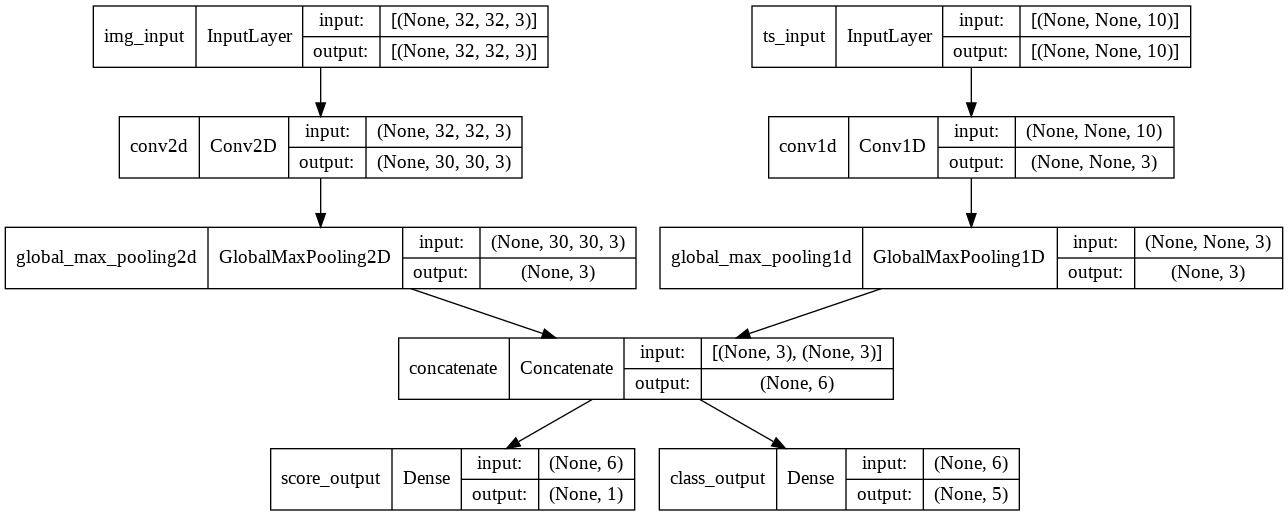

In [49]:
# Now, let's visualize the model
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [54]:
# we can specify different losses to different outputs, by passing the loss 
# functions as a list. Likewise for metrics:

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
             [
              keras.metrics.MeanAbsolutePercentageError(),
              keras.metrics.MeanAbsoluteError(),
             ],
             [keras.metrics.CategoricalAccuracy()]
    ]
)

In [53]:
# The same thing can be achieved using dicts, which is more readable.
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0}  # gives weights to the outputs
)

In [55]:
# You could also choose not to compute a loss for certain outputs:

# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

In [56]:
# Let's use this compilation for the next steps
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

### Multi-NumPy:

In [57]:
# Let's now generate some numpy data:

# Inputs:
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))

# Outputs:
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

In [58]:
# To pass data to a multi-input or multi-output model, you can:
# - Pass lists of NumPy arrays:
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

4/4 [==============================] - 3s 25ms/step - loss: 11.4477 - score_output_loss: 1.4073 - class_output_loss: 10.0404


In [59]:
# - Pass dicts 
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1
)

4/4 [==============================] - 1s 34ms/step - loss: 10.5355 - score_output_loss: 0.5887 - class_output_loss: 9.9468


### Multi-Dataset:

In [60]:
# Similarly, you can fit your model using a tf.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 [==============================] - 1s 36ms/step - loss: 10.2496 - score_output_loss: 0.3614 - class_output_loss: 9.8881


## Using callbacks

Callbacks in Keras are objects that are called at different points during training. Some uses can be:
- Doing validation at different points during training.
- Checkpointing the model.
- Changing the learning rate.
- Doing fine-tuning the top layers.
- Sending emails or messages when training ends or a certain threshold is exceeded.

In [61]:
# Callbacks are passed directly to 'fit()'

model = get_compiled_model()

callbacks = [
  keras.callbacks.EarlyStopping(
      monitor="val_loss",  # stop training the val loss does not improve
      min_delta=1e-2,  # more that 1e-3 
      patience=2,  # for at least 2 epochs
      verbose=1
  )             
]

model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,  # pass the callbacks
    validation_split=0.2
)

Epoch 1/20
625/625 [==============================] - 7s 9ms/step - loss: 0.3618 - sparse_categorical_accuracy: 0.8978 - val_loss: 0.2135 - val_sparse_categorical_accuracy: 0.9357
Epoch 2/20
625/625 [==============================] - 5s 9ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.1650 - val_sparse_categorical_accuracy: 0.9505
Epoch 3/20
625/625 [==============================] - 5s 8ms/step - loss: 0.1192 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.1562 - val_sparse_categorical_accuracy: 0.9534
Epoch 4/20
625/625 [==============================] - 5s 7ms/step - loss: 0.0944 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.1420 - val_sparse_categorical_accuracy: 0.9581
Epoch 5/20
625/625 [==============================] - 5s 7ms/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.1403 - val_sparse_categorical_accuracy: 0.9596
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 0.0655 - sparse_categorica

In [62]:
# Another example: Checkpointing models

model = get_compiled_model()

callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath="my_model_{epoch}",  # path where to save the model, name includes the current epoch.
                 save_best_only=True,  # only save the model if 'val_loss' has improved
                 monitor="val_loss",
                 verbose=1
             )
]

model.fit(
    x_train,
    y_train,
    epochs=2,
    batch_size=64,
    callbacks=callbacks,  # pass the callbacks
    validation_split=0.2
)

Epoch 1/2
619/625 [============================>.] - ETA: 0s - loss: 0.3683 - sparse_categorical_accuracy: 0.8955
Epoch 00001: val_loss improved from inf to 0.22182, saving model to my_model_1
INFO:tensorflow:Assets written to: my_model_1/assets
625/625 [==============================] - 8s 11ms/step - loss: 0.3670 - sparse_categorical_accuracy: 0.8960 - val_loss: 0.2218 - val_sparse_categorical_accuracy: 0.9323
Epoch 2/2
611/625 [============================>.] - ETA: 0s - loss: 0.1717 - sparse_categorical_accuracy: 0.9485
Epoch 00002: val_loss improved from 0.22182 to 0.17184, saving model to my_model_2
INFO:tensorflow:Assets written to: my_model_2/assets
625/625 [==============================] - 4s 7ms/step - loss: 0.1706 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.1718 - val_sparse_categorical_accuracy: 0.9490


In [65]:
# Model Checkpointing can be used to restore the training from the last saved 
# state in case training gets randomly interrupted.

import os

# Prepare a directory to store the checkpoints
checkpoint_dir="./ckpt"
os.makedirs(checkpoint_dir, exist_ok=True)

# Restore the latest model or create a new one if there is no checkpoint available
def make_or_restore_model():
  # Get the checkpoints
  checkpoint_names = os.listdir(checkpoint_dir)
  checkpoints = list(map(lambda x: os.path.join(checkpoint_dir, x), checkpoint_names))

  if checkpoints:
    # If there are checkpoints, we find the last one to return it
    latest_checkpoint = max(checkpoints, key=os.path.getctime)
    model = keras.models.load_model(latest_checkpoint)
  else:
    # There are no checkpoints, so we return the compiled model
    model =  get_compiled_model()

  return model

model = make_or_restore_model()

callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}",
                 save_freq=100  # save a model every 100 batches
             )
]

# Continue training or start training the model
model.fit(
    x_train,
    y_train,
    epochs=1,
    callbacks=callbacks
)

1563/1563 [==============================] - 24s 15ms/step - loss: 0.3030 - sparse_categorical_accuracy: 0.9111


### Writing custom callbacks

In [66]:
# Here's a simple example saving a list of per-batch loss values during 
# training:

class LossHistory(keras.callbacks.Callback):  # Derive from Callback
  def on_train_begin(self, logs):
    self.per_batch_losses = []

  def on_batch_end(self, batch, logs):
    self.per_batch_losses.append(logs.get("loss"))

## Using learning rate schedules (learning rate decay):
The learning rate schedule can be:
- **Static:** as a function of the current epochs or batch.
- **Dynamic:** responding to the current behaviour of the model, for example the validation loss).


In [69]:
# Using static learning rate schedules:

# First, we define the schedule.
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# And then we create the optimizer with the previous defined schedule.
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

To implement dynamic learning rate schedules, you have to use callbacks instead of the optimizer. See 'ReduceLROnPlateau'.

## Using Tensorboard

TensorBoard provides you with:
- Live plots of the loss and metrics for training and evaluation.
- Visualizations of the histograms of your layer activations. 
- 3D visualizations of the embedding spaces learning by the 'Embedding' layers if exist.

In [ ]:
# How to use tensorboard:
!pip install tensorboard
!tensorboard --logdir=/full_path_to_your_logs

In [70]:
# To write the logs, you must use the tensorboard callback:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",  # where to write the logs
    histogram_freq=0,  # how often to log histogram visualizations
    embeddings_freq=0,  # how often to log embedding visualizations
    update_freq="epoch",  # how often to write logs
)